flattened data for scikit-learn baselines
Training Logistic Regression 
LogReg Acc: 0.9255, F1-macro: 0.9245
Training Random Forest 
RF Acc: 0.9705, F1-macro: 0.9703
Training PyTorch MLP (30-20-10)
Epoch 1/10 - loss: 0.6636
Epoch 2/10 - loss: 0.2661
Epoch 3/10 - loss: 0.2153
Epoch 4/10 - loss: 0.1832
Epoch 5/10 - loss: 0.1651
Epoch 6/10 - loss: 0.1497
Epoch 7/10 - loss: 0.1374
Epoch 8/10 - loss: 0.1273
Epoch 9/10 - loss: 0.1192
Epoch 10/10 - loss: 0.1121
MLP Acc: 0.9594, F1-macro: 0.9591
Extracting 20-neuron activations for trained model (MNIST test)...
Constructing an untrained model and extracting activations...
Running t-SNE on trained activations...
Running t-SNE on untrained activations...
Evaluating trained MLP on Fashion-MNIST test set...
MLP on Fashion-MNIST - Acc: 0.0680, F1-macro: 0.0479
Getting activations for Fashion-MNIST (20-neuron layer)...
Running t-SNE on Fashion-MNIST activations...
Summary
MLP (30-20-10) on MNIST test: Acc=0.9594, F1-macro=0.9591
LogisticRegression o

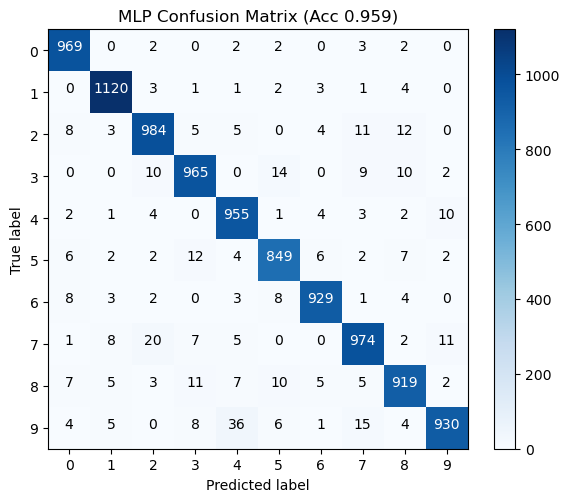

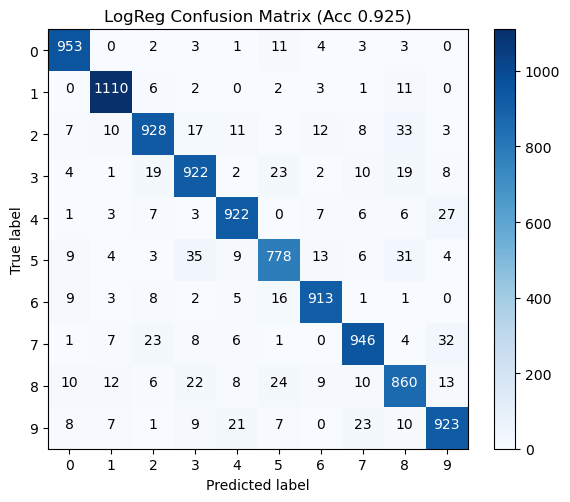

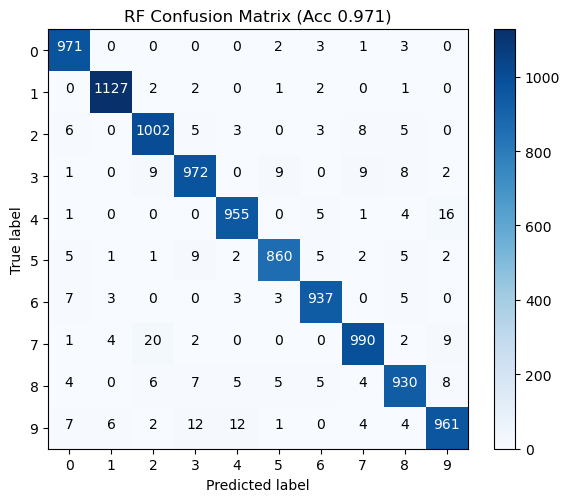

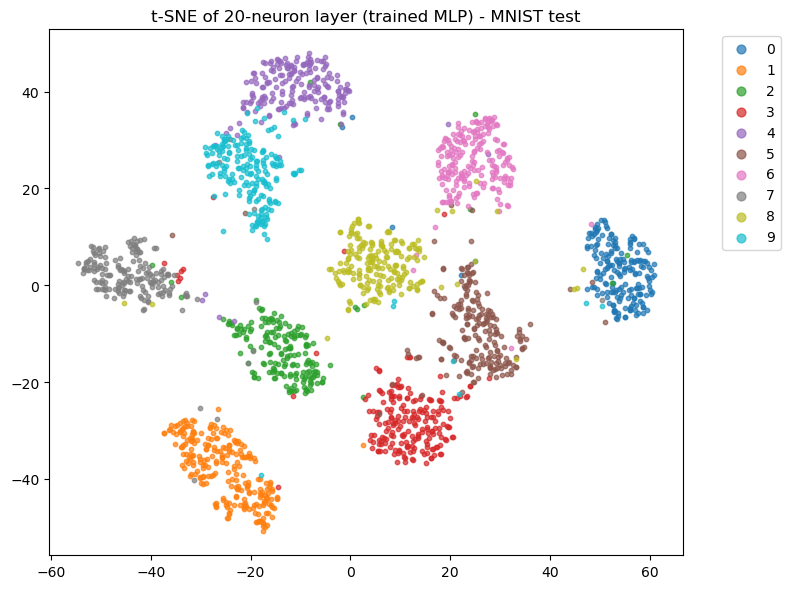

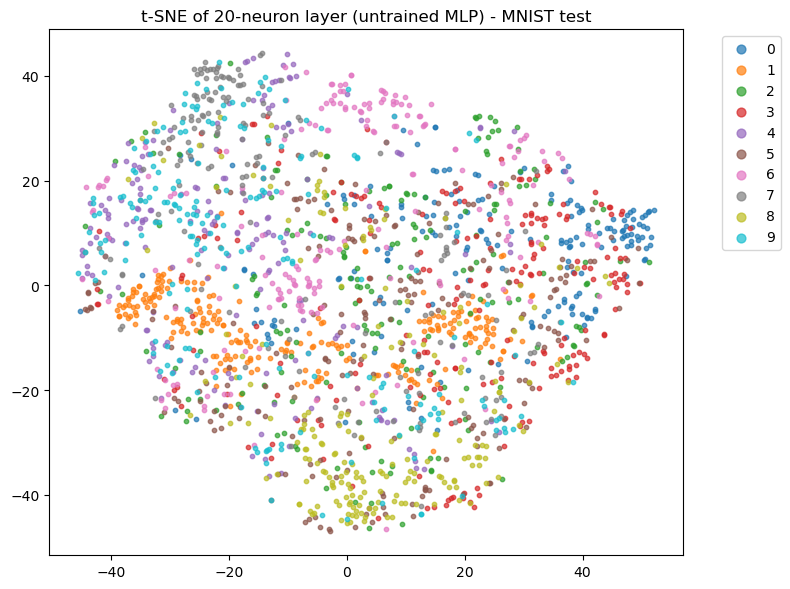

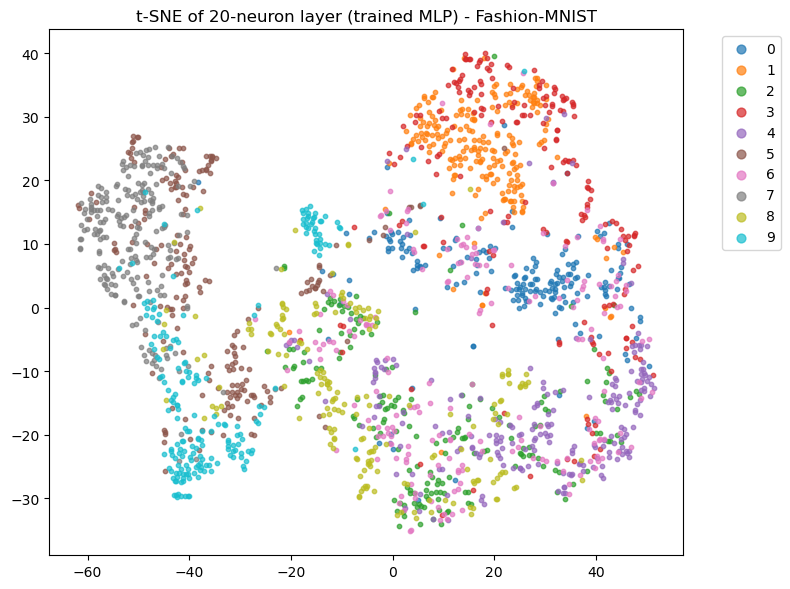

In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import itertools
import os

 
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

BATCH_SIZE = 256
epochs = 10
lr = 1e-3
subset_per_class = None  #int (e.g., 2000) for stratified subset per class to reduce compute, or None for full
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tsne_perplexity = 30   #parameter controlling local vs global neighborhood size for visualization.
tsne_iterations= 1000  #Number of optimization iterations
random_state = SEED
# OUTPUT_DIR = "output_plots"


#  set how images are preprocessed and load MNIST (train + test) and Fashion-MNIST (test) datasets.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)) ])  #Chains image preprocessing steps
mnist_train = datasets.MNIST(root="data", train=True, download=True, transform=transform)  #download the data to root="data" if needed, train=True/False selects train/test split
mnist_test = datasets.MNIST(root="data", train=False, download=True, transform=transform)
fashion_test = datasets.FashionMNIST(root="data", train=False, download=True, transform=transform)


# picks the same number of examples per class so the smaller dataset stays balanced.
def stratified_subset(dataset, per_class):  
    if per_class is None:                   #dataset labels into a NumPy array (PyTorch stores labels in .targets)
        return dataset
    labels = np.array(dataset.targets)
    idxs = []
    for c in range(10):                    #loop over class labels 0 to 9
        c_idxs = np.where(labels == c)[0]
        rng = np.random.default_rng(SEED + c)
        chosen = rng.choice(c_idxs, size=min(per_class, len(c_idxs)), replace=False)   #Randomly choose up to per_class indices for this class (no repeats).
        idxs.extend(chosen.tolist())
    return Subset(dataset, idxs)

train_dataset = stratified_subset(mnist_train, subset_per_class)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=False)
fashion_loader = DataLoader(fashion_test, batch_size=BATCH_SIZE, shuffle=False)

# Utility to flatten batches, useful when feeding linear layers.
def flatten_tensor(x):
    return x.view(x.size(0), -1)   # for MNIST: [B, 1, 28, 28] → [B, 784]

#  Defining a new neural network class. The model compresses the pixel values through 30->20 neurons.
class MLP20(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 30)
        self.fc2 = nn.Linear(30, 20)
        self.fc3 = nn.Linear(20, 10)  #converts 20 numbers into 10 logits, one per class (digits 0–9).
        self.act = nn.ReLU()
    def forward(self, x, return_h=False):
        x = x.view(x.size(0), -1)   #flatten batches
        x = self.act(self.fc1(x))   #Apply first linear layer, then ReLU activation. Output shape [B,30].
        h = self.act(self.fc2(x))   #[B,20]
        out = self.fc3(h)           #[B,10] --> logits. final raw scores
        if return_h:
            return out, h
        return out

# Train: forward -> loss -> backward -> update over batches and epochs, printing epoch loss.
def train(model, loader, epochs=epochs, lr=lr):
    model.train()
    opt = optim.Adam(model.parameters(), lr=lr)  #optimizer that will update model weights.
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        total_loss = 0.0    
        for xb, yb in loader:  #xb shape [B,C,H,W] and yb shape [B]
            opt.zero_grad()
            logits = model(xb)  #forward pass: computes logits of shape [B,10]
            loss = loss_fn(logits, yb)
            loss.backward()
            opt.step()
            total_loss += loss.item() * xb.size(0)
        avg = total_loss / len(loader.dataset)
        print(f"Epoch {epoch}/{epochs} - loss: {avg:.4f}")   #epoch progress and average loss.
    return model


def evaluate_model(model, loader):
    # model.to(DEVICE)
    model.eval()  #switch to evaluation mode: disables training-only behaviors
    preds = []
    trues = []
    with torch.no_grad():
        for xb, yb in loader:
            # xb = xb.to(DEVICE)
            logits = model(xb)
            p = logits.argmax(dim=1).cpu().numpy()  #NumPy array of predicted labels for the batch.
            preds.extend(p.tolist())  #append the batch predictions/true labels to the lists
            trues.extend(yb.numpy().tolist())
    return np.array(trues), np.array(preds)


# extracting 20-d hidden features for every sample, used for t-SNE visualizations
def layer_activations(model, loader):
    # model.to(DEVICE)
    model.eval()
    activations = []
    labels = []
    with torch.no_grad():
        for xb, yb in loader:
            # xb = xb.to(DEVICE)
            _, h = model(xb, return_h=True)   #ignoring logits and keeping h (20 dim hidden activation)
            activations.append(h.cpu().numpy())
            labels.extend(yb.numpy().tolist())
    activations = np.vstack(activations)
    labels = np.array(labels)
    return activations, labels

# produce (X, y) NumPy arrays of flattened pixels and labels
def flat_data(dataset):
    loader = DataLoader(dataset, batch_size=1024, shuffle=False)
    xs = []  
    ys = []
    for xb, yb in loader:
        xs.append(flatten_tensor(xb).numpy())
        ys.append(yb.numpy())
    return np.vstack(xs), np.hstack(ys)

print("flattened data")
X_train_flat, y_train_flat = flat_data(train_dataset)
X_test_flat, y_test_flat = flat_data(mnist_test)

#Train MLP in PyTorch 
print("Training MLP (30-20-10)")
mlp = MLP20()
mlp = train(mlp, train_loader, epochs=epochs, lr=lr)

# Evaluate MLP on MNIST test
y_true_mlp, y_pred_mlp = evaluate_model(mlp, test_loader)
mlp_acc = accuracy_score(y_true_mlp, y_pred_mlp)
mlp_f1 = f1_score(y_true_mlp, y_pred_mlp, average='macro')
print(f"MLP Acc: {mlp_acc:.4f}, F1-macro: {mlp_f1:.4f}")

# building a multi class logistic regression model to predict digits (0–9).
print("Training Logistic Regression ")
lr = LogisticRegression(max_iter=1000, solver='saga', multi_class='multinomial', n_jobs=-1)
lr.fit(X_train_flat, y_train_flat)  
lr_preds = lr.predict(X_test_flat)               #to predict labels for the test images.
lr_acc = accuracy_score(y_test_flat, lr_preds)
lr_f1 = f1_score(y_test_flat, lr_preds, average='macro')
print(f"LogReg Accuracy: {lr_acc:.4f}, F1-score: {lr_f1:.4f}")

print("Training Random Forest ")
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=SEED)
rf.fit(X_train_flat, y_train_flat)
rf_preds = rf.predict(X_test_flat)
rf_acc = accuracy_score(y_test_flat, rf_preds)
rf_f1 = f1_score(y_test_flat, rf_preds, average='macro')
print(f"RF Accuracy: {rf_acc:.4f}, F1-score: {rf_f1:.4f}")



# Confusion matrices
cm_mlp = confusion_matrix(y_true_mlp, y_pred_mlp)
cm_lr = confusion_matrix(y_test_flat, lr_preds)
cm_rf = confusion_matrix(y_test_flat, rf_preds)

#  Activations and t-SNE 
print("20-neuron activations for trained model (MNIST test)")
acts_trained, labels_trained = layer_activations(mlp, test_loader)

print("Constructing an untrained model and extracting activations")
mlp_untrained = MLP20()  # random init; do NOT train
acts_untrained, labels_untrained = layer_activations(mlp_untrained, test_loader)

# Subsampling for TSNE to speed up 
tsne_sample = 2000
def subsample_for_tsne(acts, labels, n=tsne_sample):
    if acts.shape[0] <= n:
        return acts, labels
    rng = np.random.default_rng(SEED)
    idx = rng.choice(np.arange(acts.shape[0]), size=n, replace=False)
    return acts[idx], labels[idx]

# at most 2000×20 arrays ready for t-SNE
acts_tr_s, labels_tr_s = subsample_for_tsne(acts_trained, labels_trained)
acts_un_s, labels_un_s = subsample_for_tsne(acts_untrained, labels_untrained)

print("t-SNE on trained activations.")
tsne = TSNE(n_components=2,  n_iter=tsne_iterations, random_state=random_state)
emb_trained = tsne.fit_transform(acts_tr_s)  #fit_transform computes pairwise affinities in high-dim space, 
# then optimizes low-dim coordinates to match those affinities.

print("t-SNE on untrained activations")
tsne2 = TSNE(n_components=2, n_iter=tsne_iterations, random_state=random_state+1)
emb_untrained = tsne2.fit_transform(acts_un_s)

#  Test MLP on Fashion-MNIST 
print("trained MLP on Fashion-MNIST test set")
y_true_fash, y_pred_fash = evaluate_model(mlp, fashion_loader)
fash_acc = accuracy_score(y_true_fash, y_pred_fash)
fash_f1 = f1_score(y_true_fash, y_pred_fash, average='macro')
print(f"MLP on Fashion-MNIST - Acc: {fash_acc:.4f}, F1-score: {fash_f1:.4f}")

print("activations for Fashion-MNIST (20-neuron layer)")
acts_fash, labels_fash = layer_activations(mlp, fashion_loader)
acts_fash_s, labels_fash_s = subsample_for_tsne(acts_fash, labels_fash)
print("t-SNE on fashion-MNIST activations")
tsne3 = TSNE(n_components=2, perplexity=min(30, max(5, acts_fash_s.shape[0]//10)),
             n_iter=tsne_iterations, random_state=random_state+2, init='pca')
emb_fashion = tsne3.fit_transform(acts_fash_s)

  

def confusion(cm, title, fname):
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(10)
    plt.xticks(ticks, ticks)
    plt.yticks(ticks, ticks)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
  

confusion(cm_mlp, f"MLP Confusion Matrix (Acc {mlp_acc:.3f})", "cm_mlp.png")
confusion(cm_lr, f"LogReg Confusion Matrix (Acc {lr_acc:.3f})", "cm_lr.png")
confusion(cm_rf, f"RF Confusion Matrix (Acc {rf_acc:.3f})", "cm_rf.png")


def tsne(emb, labels, title):
    plt.figure(figsize=(8,6))
    for c in range(10):
        idx = labels == c
        plt.scatter(emb[idx,0], emb[idx,1], label=str(c), s=10, alpha=0.7)
    plt.legend(markerscale=2, bbox_to_anchor=(1.05,1), loc='upper left')
    plt.title(title)
    plt.tight_layout()

tsne(emb_trained, labels_tr_s, "t-SNE of 20-neuron layer (trained MLP) - MNIST test", "tsne_trained_mnist.png")
tsne(emb_untrained, labels_un_s, "t-SNE of 20-neuron layer (untrained MLP) - MNIST test", "tsne_untrained_mnist.png")
tsne(emb_fashion, labels_fash_s, "t-SNE of 20-neuron layer (trained MLP) - Fashion-MNIST", "tsne_trained_fashion.png")



print("Summary")
print(f"MLP (30-20-10) on MNIST test: Acc={mlp_acc:.4f}, F1-macro={mlp_f1:.4f}")
print(f"LogisticRegression on MNIST test: Acc={lr_acc:.4f}, F1-macro={lr_f1:.4f}")
print(f"RandomForest on MNIST test: Acc={rf_acc:.4f}, F1-macro={rf_f1:.4f}")
print(f"MLP tested on Fashion-MNIST: Acc={fash_acc:.4f}, F1-macro={fash_f1:.4f}")
# print(f"Plots saved to: {os.path.abspath(OUTPUT_DIR)}")

print("\nTop-level observations you should expect (inspect plots & confusion matrices):")
print("- t-SNE trained vs untrained: trained model should show clusters by digit; untrained typically shows no clear clusters.")
print("- Misclassifications: expect confusion among visually similar digits (e.g., 4 vs 9, 3 vs 5, 7 vs 1 depending on style).")
print("- Generalization to Fashion-MNIST: low accuracy — embeddings will not cluster meaningfully by digit classes, since Fashion images differ semantically from digits.")
print("- Compare baselines: LogisticRegression often competitive; RandomForest can be decent but slower and sometimes worse on raw pixels.")

# Print example classification report for MLP
print("\nClassification report (MLP on MNIST test):")
print(classification_report(y_true_mlp, y_pred_mlp, digits=4))

